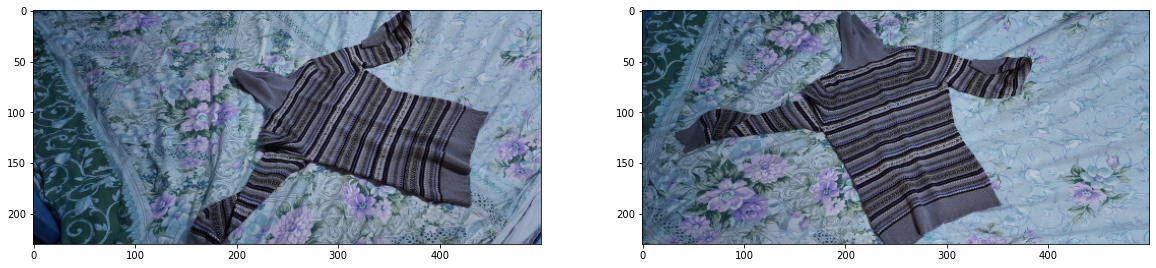

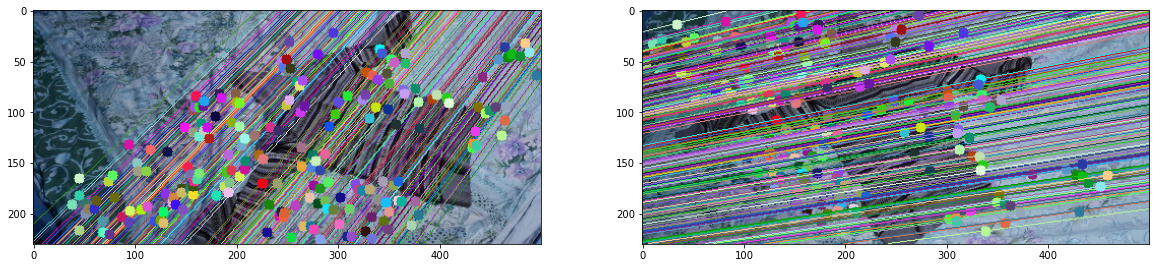

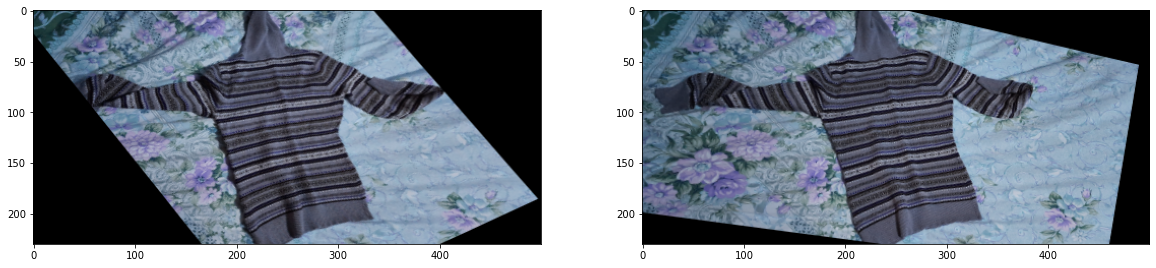

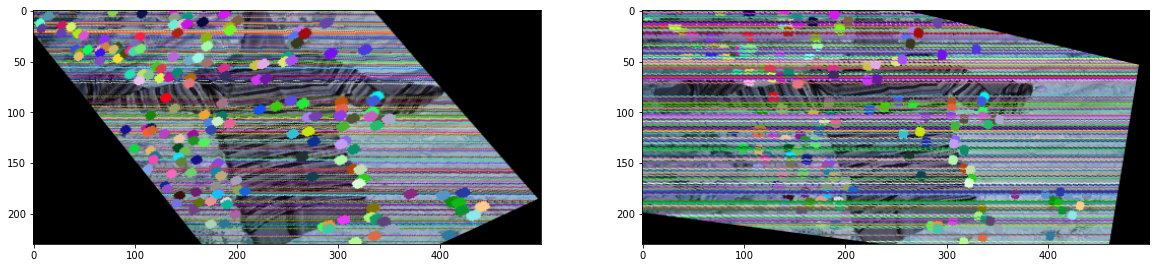

True

In [1]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

ratio = 0.75
reprojThresh = 4.0

def detectAndDescribe(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        pts1 = []
        pts2 = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                pts1.append(m[0].trainIdx)
                pts2.append(m[0].queryIdx)
        ptsA = np.float32([kpsA[i] for i in pts2])
        ptsB = np.float32([kpsB[i] for i in pts1])
        return (ptsA, ptsB)
    
def drawlines(image1, image2, lines, pts1, pts2):
    _, c, _ = image1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0]  *c) / r[1] ])
        image1 = cv2.line(image1, (x0, y0), (x1, y1), color, 1)
        image1 = cv2.circle(image1, tuple(pt1), 5, color, -1)
        image2 = cv2.circle(image2, tuple(pt2), 5, color, -1)
    return image1

imageA = cv2.imread("5.jpg")
imageB = cv2.imread("6.jpg")

imageA = imutils.resize(imageA, width=500)
imageB = imutils.resize(imageB, width=500)
h, w, _ = imageA.shape

imageA_ = imageA.copy()
imageB_ = imageB.copy()

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA)
plt.subplot(122), plt.imshow(imageB)
plt.show()

(kpsA, featuresA) = detectAndDescribe(imageA)
(kpsB, featuresB) = detectAndDescribe(imageB)

(ptsA, ptsB) = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
ptsA = np.int32(ptsA)
ptsB = np.int32(ptsB)

F, mask = cv2.findFundamentalMat(ptsA, ptsB, cv2.FM_LMEDS)
ptsA = ptsA[mask.ravel()==1]
ptsB = ptsB[mask.ravel()==1]

res, H1, H2 = cv2.stereoRectifyUncalibrated(ptsA, ptsB, F, (w, h), 10)

lines1 = cv2.computeCorrespondEpilines(ptsB.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA, imageB, lines1, ptsA, ptsB)

lines2 = cv2.computeCorrespondEpilines(ptsA.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB, imageA, lines2, ptsB, ptsA)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("resA.jpg", imageA1) 
cv2.imwrite("resB.jpg", imageA2) 

imageA_ = cv2.warpPerspective(imageA_, H1, (w, h))
imageB_ = cv2.warpPerspective(imageB_, H2, (w, h))

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA_)
plt.subplot(122), plt.imshow(imageB_)
plt.show()
cv2.imwrite("transformedA.jpg", imageA_) 
cv2.imwrite("transformedB.jpg", imageB_) 

imageA = cv2.warpPerspective(imageA, H1, (w, h))
imageB = cv2.warpPerspective(imageB, H2, (w, h))

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA)
plt.subplot(122), plt.imshow(imageB)
plt.show()
cv2.imwrite("transformedresA.jpg", imageA) 
cv2.imwrite("transformedresB.jpg", imageB)